# Models > Neural Networks (MLP)

<div class="alert alert-info">Estimate and tune a Multi-Layer Perceptron model for binary classification</div>

In [35]:
import os

import polars as pl
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pyrsm as rsm

In [36]:
## setup pyrsm for autoreload
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

### Example

As an example we will use a dataset that describes the survival status of individual passengers on the Titanic. The principal source for data about Titanic passengers is the Encyclopedia Titanic. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay. Suppose we want to investigate which factors are most strongly associated with the chance of surviving the sinking of the Titanic. Lets focus on four variables in the database:

- survived = a factor with levels `Yes` and `No`
- pclass = Passenger Class (1st, 2nd, 3rd). This is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower
- sex = Sex (female, male)
- age = Age in years

Select `survived` as the response variable and `Yes` in **Choose level**. Select `pclass`, `sex` and `age` as the explanatory variables. In contrast to Logistic Regression, a Machine Learning model like a Random Forest does not provide coefficients or odds-ratios that we can interpret. Instead, the model provides predictions that we need to evaluate for accuracy. We will also use different plots to better understand what the Random Forest model is telling us about the connection between the explanatory variables (i.e., features) and the response variable (i.e., target).


In [37]:
titanic = pl.read_parquet("https://github.com/radiant-ai-hub/raw/refs/heads/main/examples/data/data/titanic.parquet")
titanic

pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked
enum,enum,enum,f64,i32,i32,f64,str,str,enum
"""1st""","""Yes""","""female""",29.0,0,0,211.337494,"""Allen, Miss. Elisabeth Walton""","""B5""","""Southampton"""
"""1st""","""Yes""","""male""",0.9167,1,2,151.550003,"""Allison, Master. Hudson Trevor""","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",2.0,1,2,151.550003,"""Allison, Miss. Helen Loraine""","""C22 C26""","""Southampton"""
"""1st""","""No""","""male""",30.0,1,2,151.550003,"""Allison, Mr. Hudson Joshua Cre…","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",25.0,1,2,151.550003,"""Allison, Mrs. Hudson J C (Bess…","""C22 C26""","""Southampton"""
…,…,…,…,…,…,…,…,…,…
"""3rd""","""No""","""male""",45.5,0,0,7.2249999,"""Youseff, Mr. Gerious""","""""","""Cherbourg"""
"""3rd""","""No""","""female""",14.5,1,0,14.4542,"""Zabour, Miss. Hileni""","""""","""Cherbourg"""
"""3rd""","""No""","""male""",26.5,0,0,7.2249999,"""Zakarian, Mr. Mapriededer""","""""","""Cherbourg"""


In [38]:
rsm.md("https://raw.githubusercontent.com/radiant-ai-hub/refs/heads/main/examples/data/data/titanic_description.md")

## Titanic

This dataset describes the survival status of individual passengers on the Titanic. The titanic data frame does not contain information from the crew, but it does contain actual ages of (some of) the passengers. The principal source for data about Titanic passengers is the Encyclopedia Titanica. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay.

## Variables

* survival - Survival (Yes, No)
* pclass - Passenger Class (1st, 2nd, 3rd)
* sex - Sex (female, male)
* age - Age in years
* sibsp - Number of Siblings/Spouses Aboard
* parch - Number of Parents/Children Aboard
* fare - Passenger Fare
* name - Name
* cabin - Cabin
* embarked - Port of Embarkation (Cherbourg, Queenstown, Southampton)

##  Notes

`pclass` is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1). If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch) some relations were ignored.  The following are the definitions used for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins, nephews/nieces, aunts/uncles, and in-laws. Some children travelled only with a nanny, therefore parch=0 for them.  As well, some travelled with very close friends or neighbors in a village, however, the definitions do not support such relations.

Note: Missing values and the `ticket` variable were removed from the data

## Related reading

<a href="http://phys.org/news/2012-07-shipwrecks-men-survive.html" target="_blank">In shipwrecks, men more likely to survive</a>

In [39]:
titanic.head()

pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked
enum,enum,enum,f64,i32,i32,f64,str,str,enum
"""1st""","""Yes""","""female""",29.0,0,0,211.337494,"""Allen, Miss. Elisabeth Walton""","""B5""","""Southampton"""
"""1st""","""Yes""","""male""",0.9167,1,2,151.550003,"""Allison, Master. Hudson Trevor""","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",2.0,1,2,151.550003,"""Allison, Miss. Helen Loraine""","""C22 C26""","""Southampton"""
"""1st""","""No""","""male""",30.0,1,2,151.550003,"""Allison, Mr. Hudson Joshua Cre…","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",25.0,1,2,151.550003,"""Allison, Mrs. Hudson J C (Bess…","""C22 C26""","""Southampton"""


The two code chunks below test if the categorical order set by the user or data owner is maintained throughout the analysis.

In [40]:
levels = titanic["pclass"].dtype.categories.to_list()
levels

['1st', '2nd', '3rd']

In [41]:
levels.reverse()
titanic = titanic.with_columns(
    pl.col("pclass").cast(pl.Enum(levels))
)
levels = titanic["pclass"].dtype.categories.to_list()
levels

['3rd', '2nd', '1st']

In [42]:
titanic.columns

['pclass',
 'survived',
 'sex',
 'age',
 'sibsp',
 'parch',
 'fare',
 'name',
 'cabin',
 'embarked']

In [43]:
evar = titanic.columns[:1] + titanic.columns[2:7]
evar

['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare']

In [44]:
clf_nn = rsm.model.mlp(
    {"titanic": titanic},
    hidden_layer_sizes=(3, 3),
    alpha=0.001,
    rvar="survived",
    lev="Yes",
    evar=evar,
)
clf_nn.summary()

Multi-layer Perceptron (NN)
Data                 : titanic
Response variable    : survived
Level                : Yes
Explanatory variables: pclass, sex, age, sibsp, parch, fare
Model type           : classification
Nr. of features      : (6, 7)
Nr. of weights       : 40
Nr. of observations  : 1,043
Hidden_layer_sizes   : (3, 3)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.886

Raw data             :
shape: (5, 6)
┌────────┬────────┬────────┬───────┬───────┬────────────┐
│ pclass ┆ sex    ┆ age    ┆ sibsp ┆ parch ┆ fare       │
│ ---    ┆ ---    ┆ ---    ┆ ---   ┆ ---   ┆ ---        │
│ enum   ┆ enum   ┆ f64    ┆ i32   ┆ i32   ┆ f64        │
╞════════╪════════╪════════╪═══════╪═══════╪════════════╡
│ 1st    ┆ female ┆ 29.0   ┆ 0     ┆ 0     ┆ 211.337494 │
│ 1st    ┆ male   ┆ 0.9167 ┆ 1     ┆ 2     ┆ 151.550

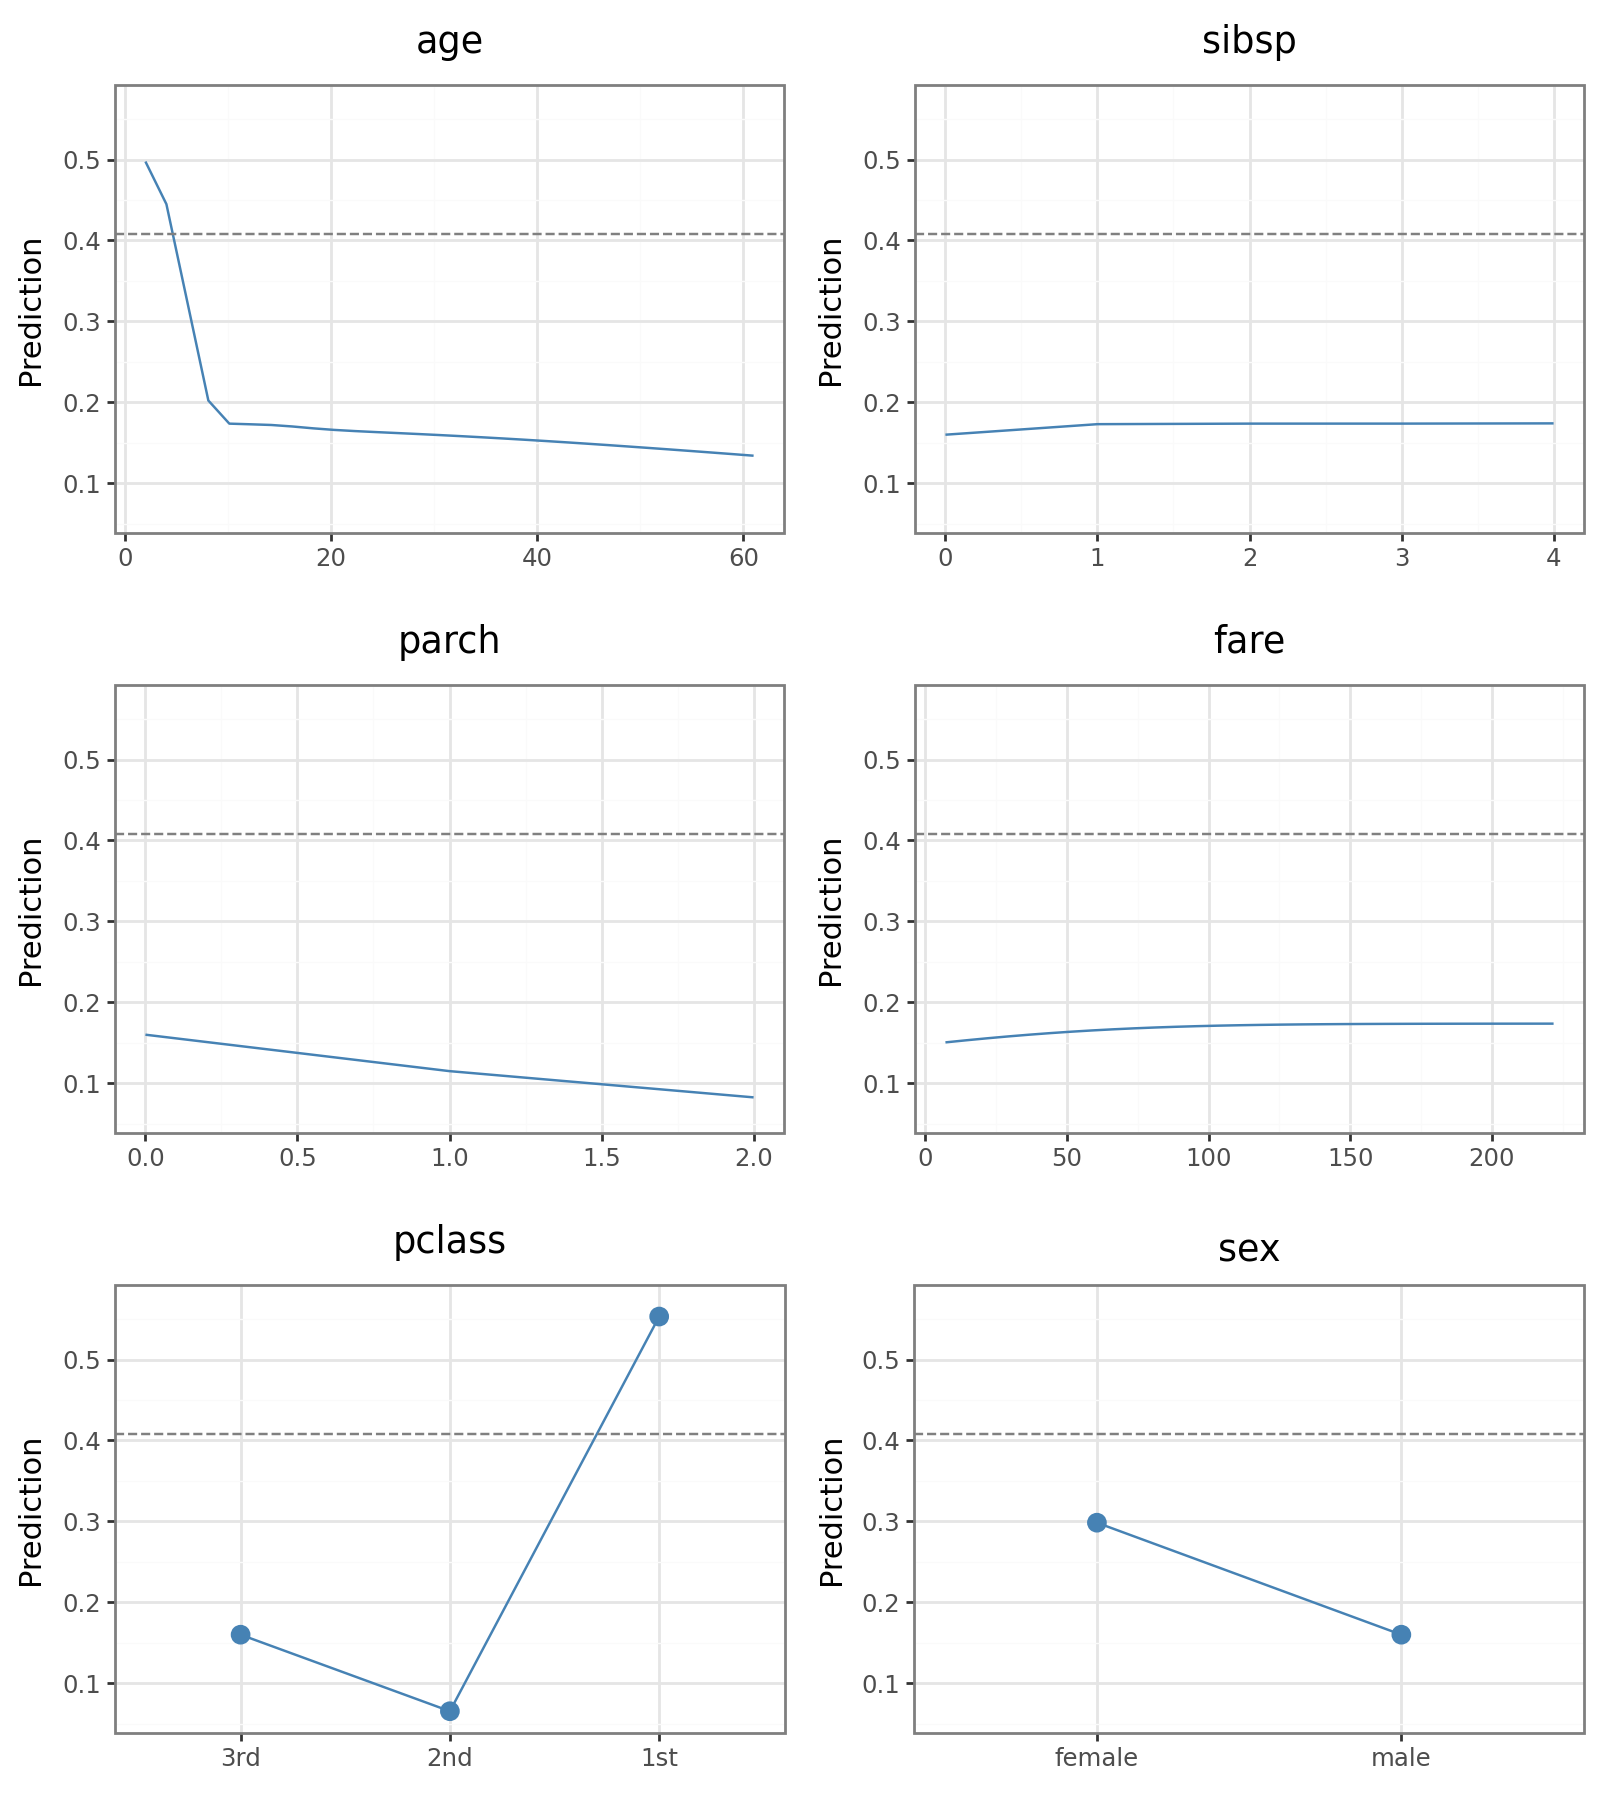

In [45]:
clf_nn.plot("pred")

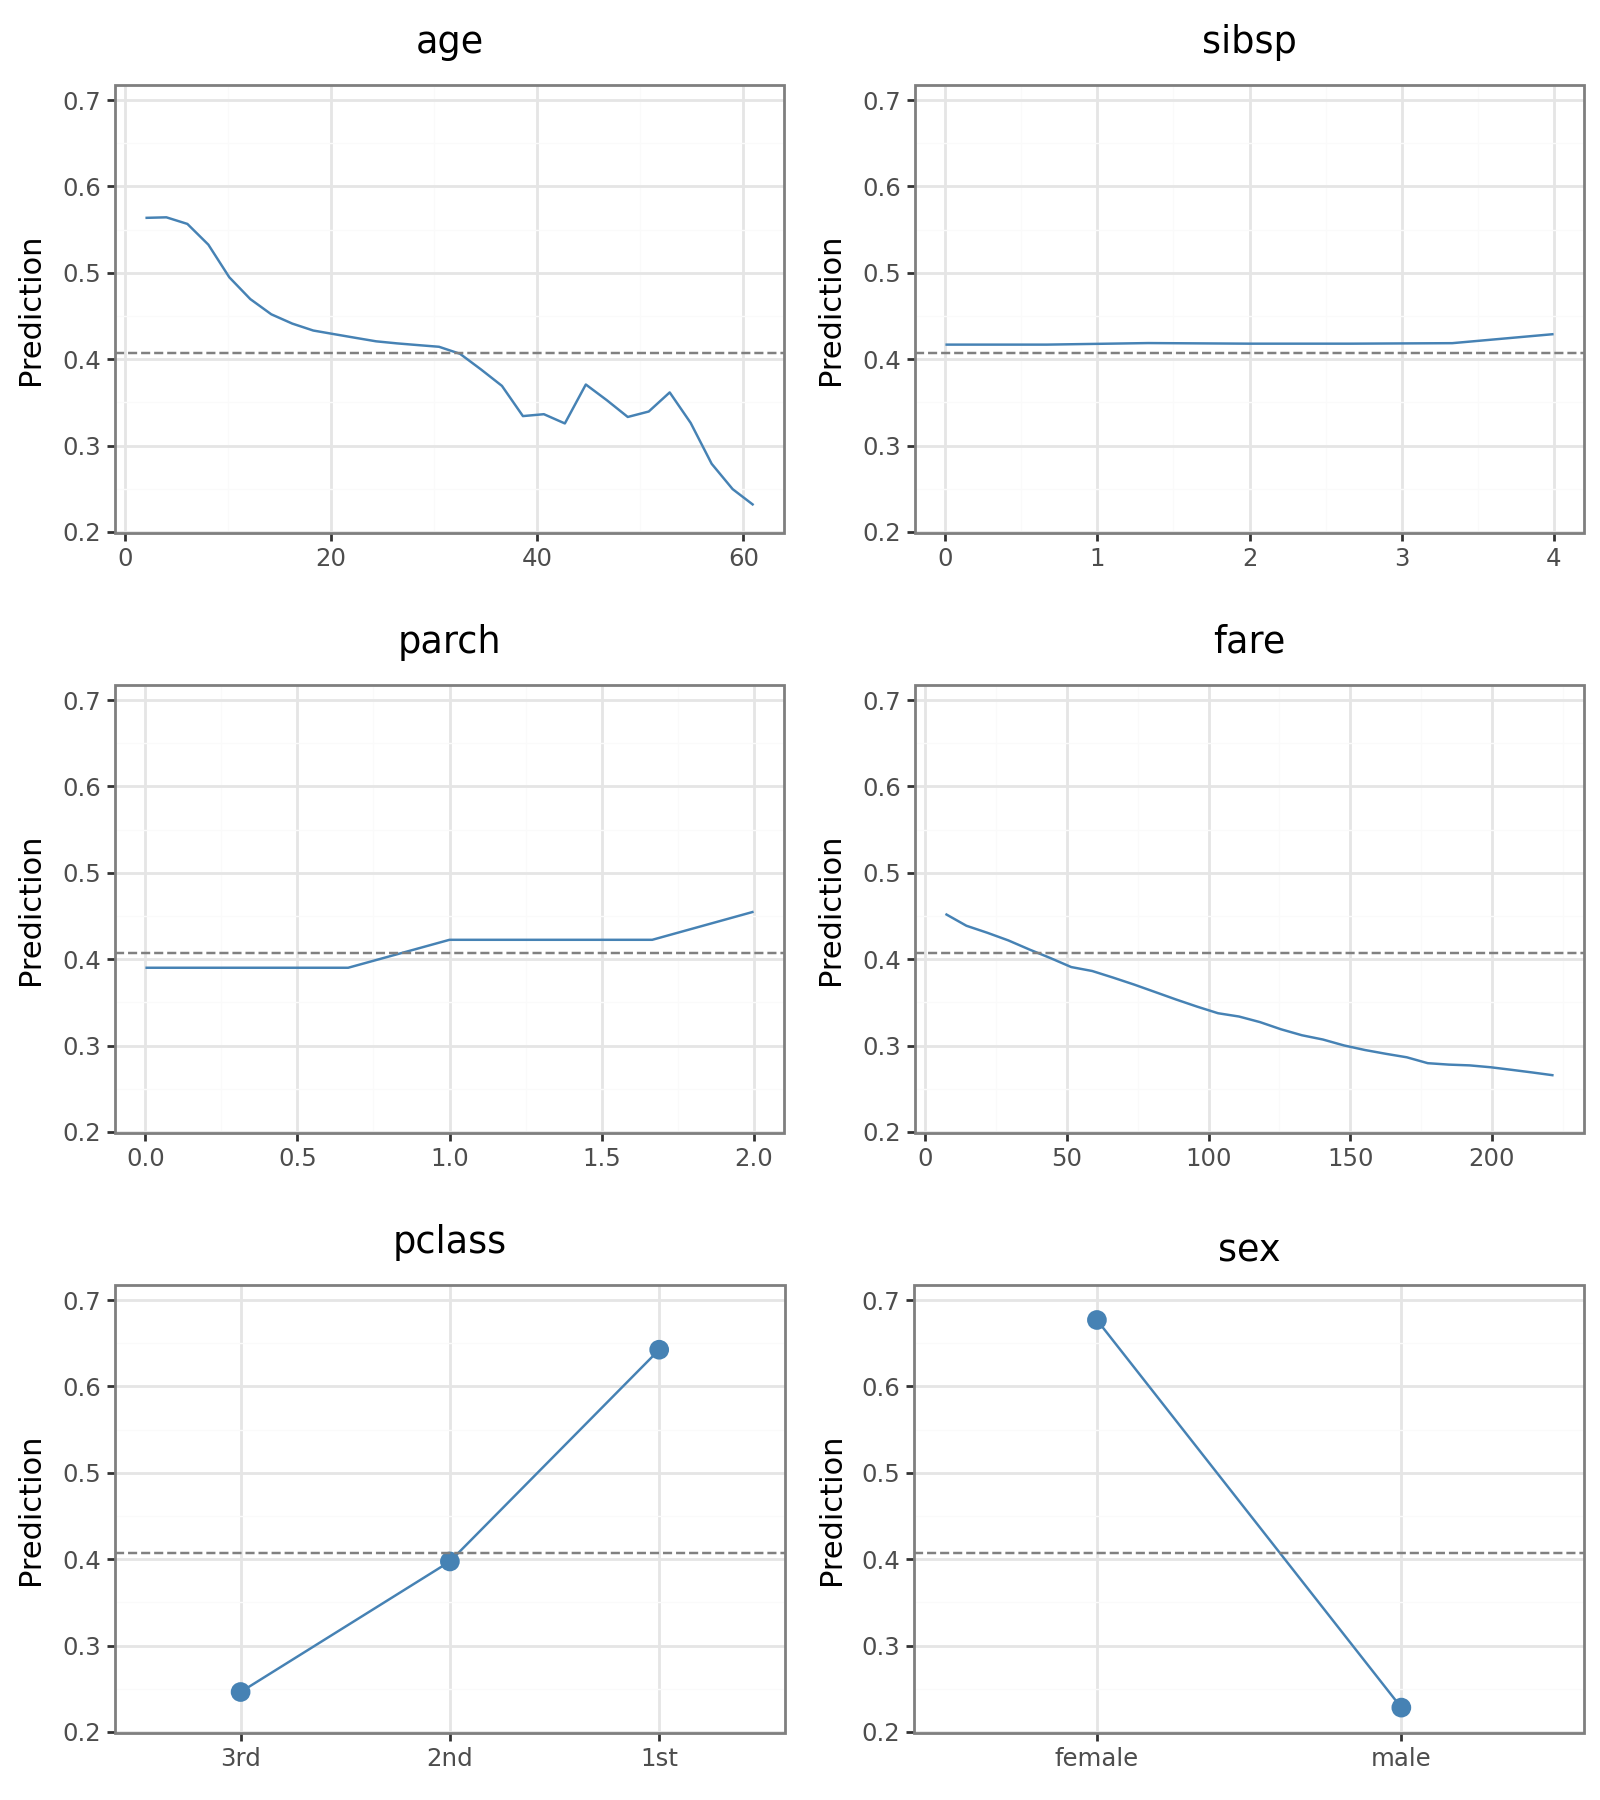

In [46]:
clf_nn.plot("pdp")

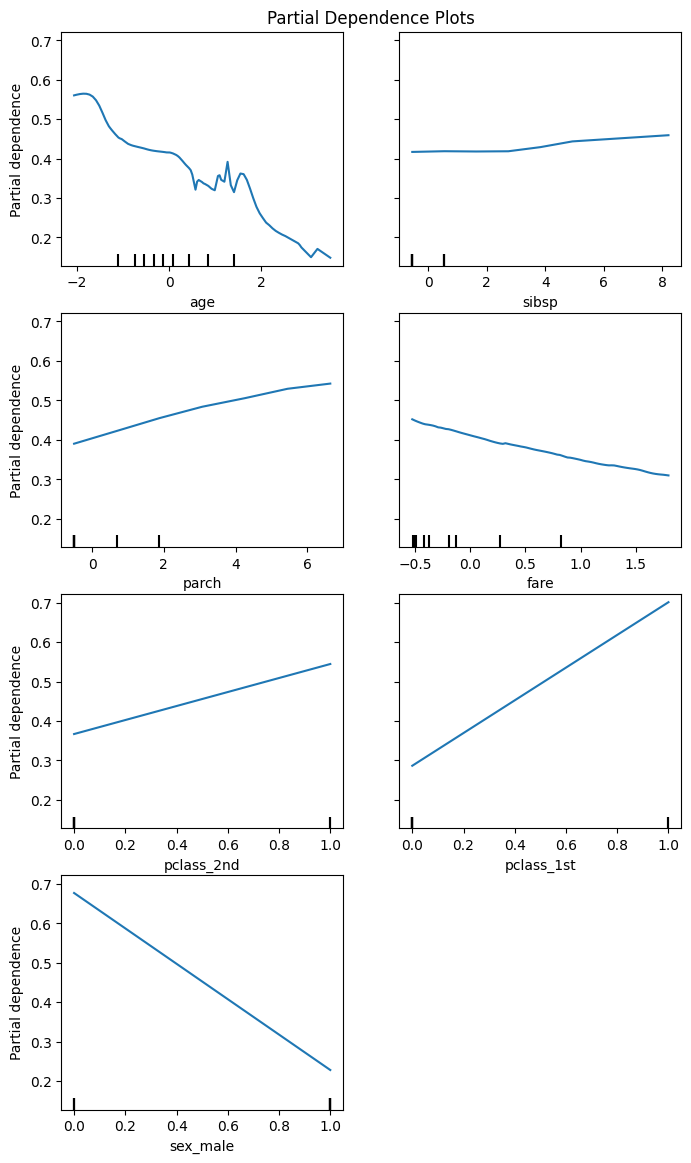

In [47]:
clf_nn.plot("pdp_sklearn")

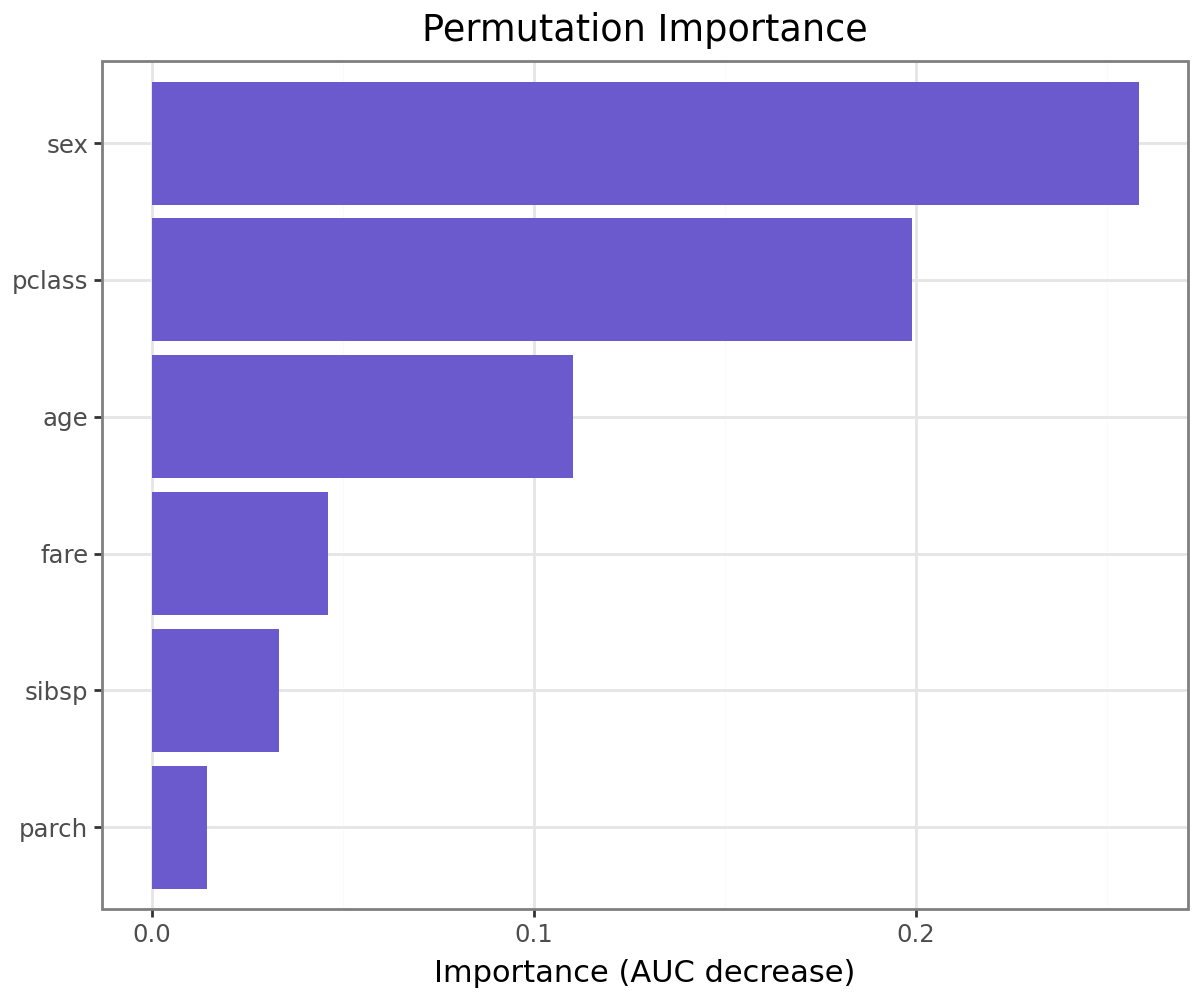

In [48]:
clf_nn.plot("pip")

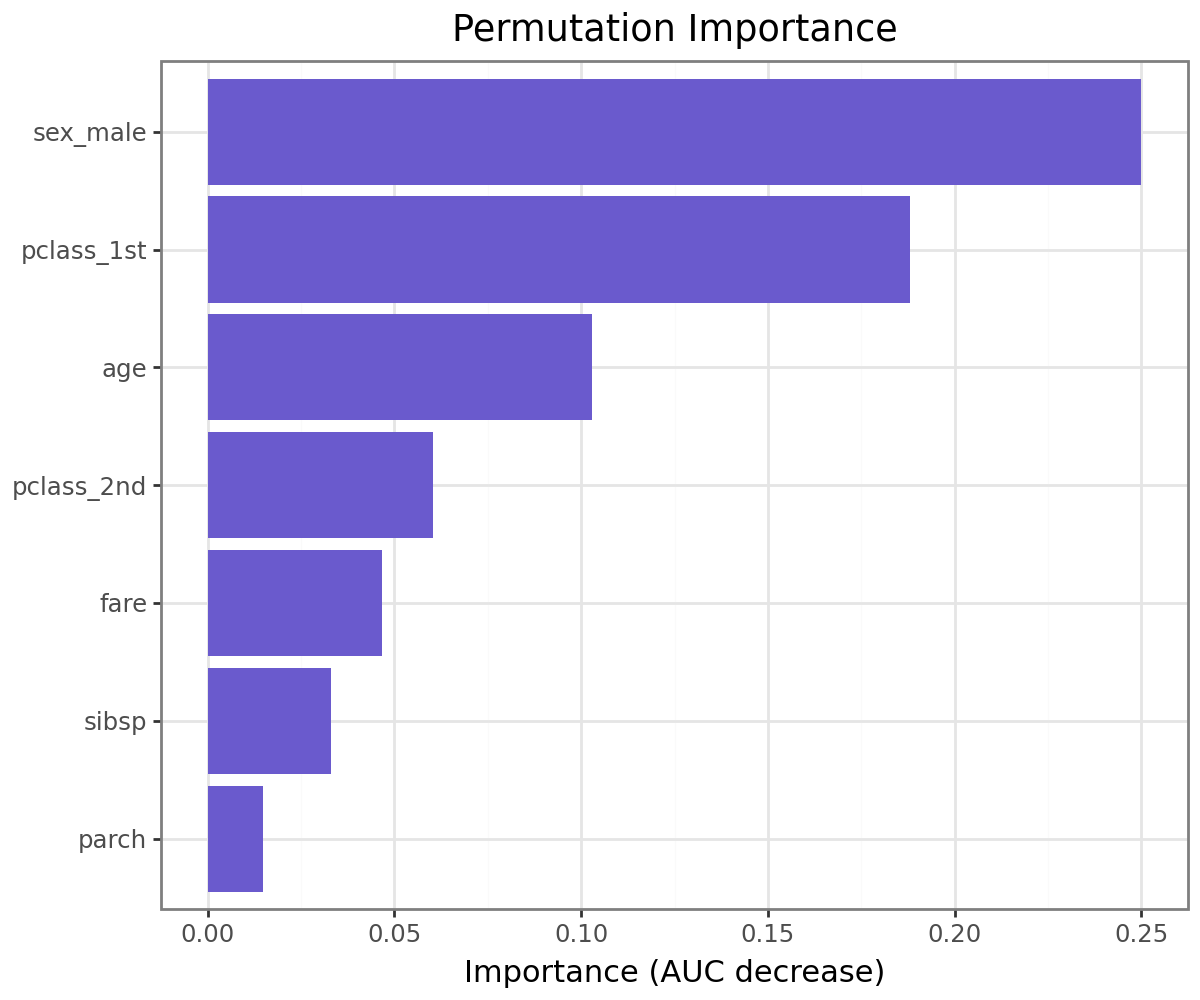

In [49]:
clf_nn.plot("pip_sklearn")

In [50]:
clf_nn.predict(titanic, dec=3)

pclass,sex,age,sibsp,parch,fare,prediction
enum,enum,f64,i32,i32,f64,f64
"""1st""","""female""",29.0,0,0,211.337,1.0
"""1st""","""male""",0.917,1,2,151.55,0.42
"""1st""","""female""",2.0,1,2,151.55,0.302
"""1st""","""male""",30.0,1,2,151.55,0.46
"""1st""","""female""",25.0,1,2,151.55,0.945
…,…,…,…,…,…,…
"""3rd""","""male""",45.5,0,0,7.225,0.136
"""3rd""","""female""",14.5,1,0,14.454,0.288
"""3rd""","""male""",26.5,0,0,7.225,0.153


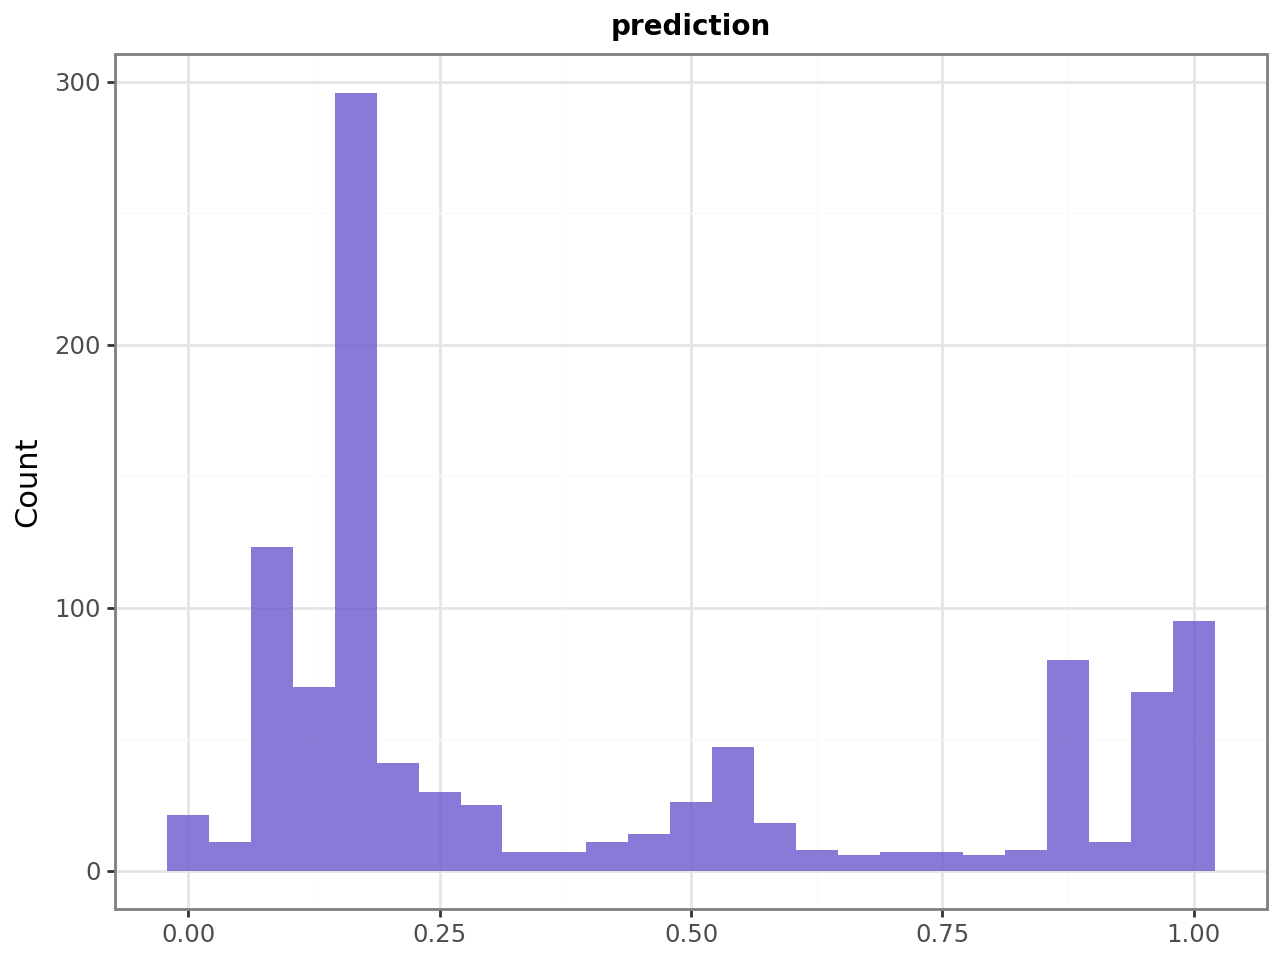

In [51]:
ds = rsm.eda.distr(clf_nn.predict(titanic).select("prediction"))
ds.plot()

In [52]:
titanic = titanic.with_columns(pred=clf_nn.predict(titanic).get_column("prediction"))
titanic

pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked,pred
enum,enum,enum,f64,i32,i32,f64,str,str,enum,f64
"""1st""","""Yes""","""female""",29.0,0,0,211.337494,"""Allen, Miss. Elisabeth Walton""","""B5""","""Southampton""",1.0
"""1st""","""Yes""","""male""",0.9167,1,2,151.550003,"""Allison, Master. Hudson Trevor""","""C22 C26""","""Southampton""",0.420158
"""1st""","""No""","""female""",2.0,1,2,151.550003,"""Allison, Miss. Helen Loraine""","""C22 C26""","""Southampton""",0.301541
"""1st""","""No""","""male""",30.0,1,2,151.550003,"""Allison, Mr. Hudson Joshua Cre…","""C22 C26""","""Southampton""",0.459987
"""1st""","""No""","""female""",25.0,1,2,151.550003,"""Allison, Mrs. Hudson J C (Bess…","""C22 C26""","""Southampton""",0.945308
…,…,…,…,…,…,…,…,…,…,…
"""3rd""","""No""","""male""",45.5,0,0,7.2249999,"""Youseff, Mr. Gerious""","""""","""Cherbourg""",0.136186
"""3rd""","""No""","""female""",14.5,1,0,14.4542,"""Zabour, Miss. Hileni""","""""","""Cherbourg""",0.287763
"""3rd""","""No""","""male""",26.5,0,0,7.2249999,"""Zakarian, Mr. Mapriededer""","""""","""Cherbourg""",0.153394


In [53]:
rsm.model.gains_tab(titanic, rvar="survived", lev="Yes", pred="pred")


cum_prop,cum_gains
f64,f64
0.0,0.0
0.100671,0.247059
0.200384,0.472941
0.300096,0.658824
0.399808,0.776471
…,…
0.600192,0.882353
0.699904,0.924706
0.799616,0.964706


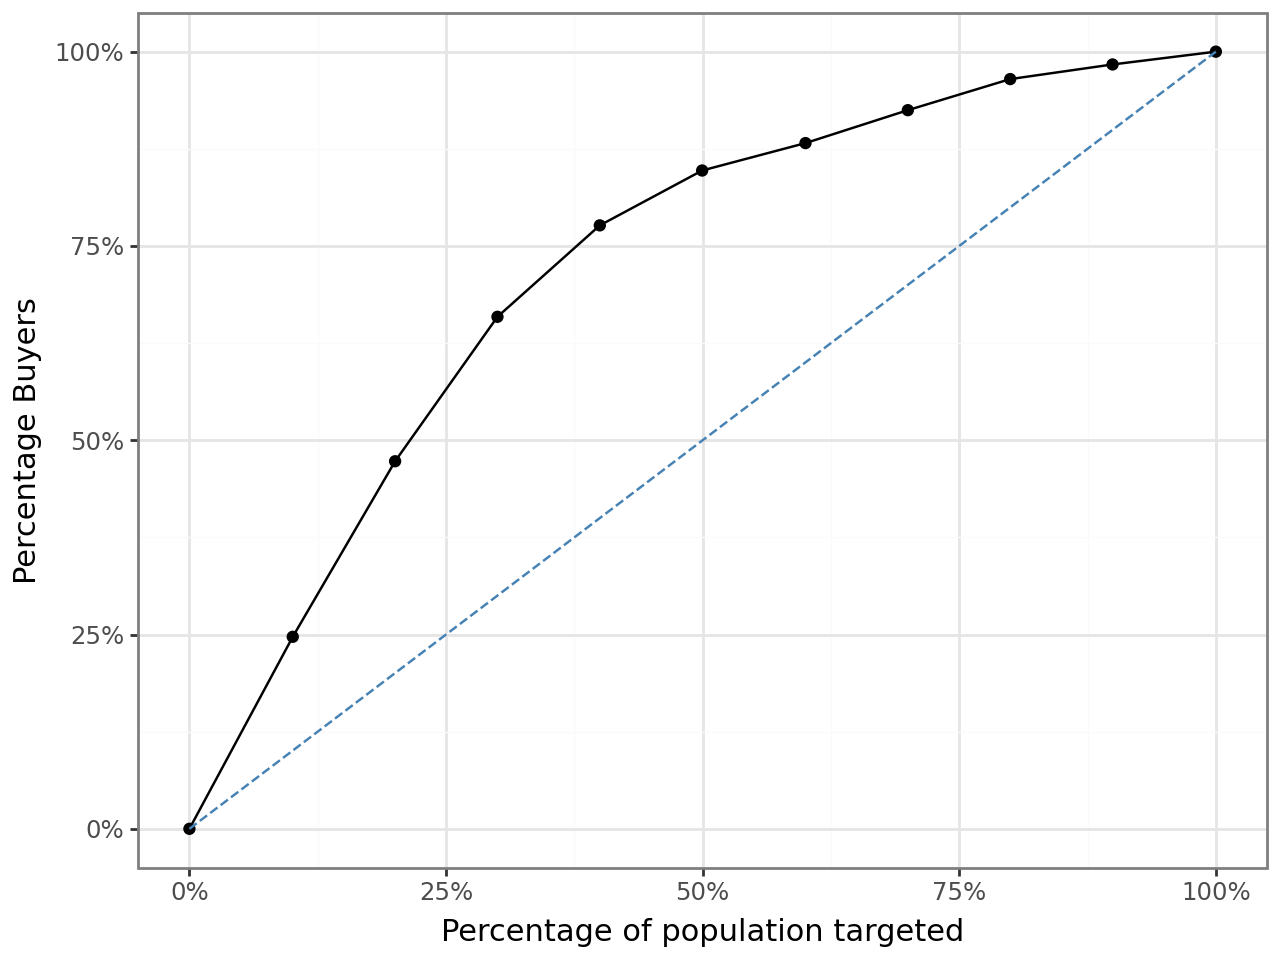

In [54]:
rsm.model.gains_plot(titanic, rvar="survived", lev="Yes", pred="pred")

In addition to the numerical output provided in the _Summary_ tab we can also evaluate the link between `survival`, `class`, `sex`, and `age` visually (see _Plot_ tab). 


## Tuning an MLP (NN) classification model

When building an MLP (Neural Network) model, there are several hyperparameters that can be tuned to improve model performance. Two key parameters we'll focus on are:

- `hidden_layer_sizes`: The number of hidden layers and the number of neurons in each hidden layer
- `alpha`: The regularization parameter (L2 penalty)

To find the optimal combination of these parameters, we'll:

1. Split our data into training (70%) and test (30%) sets
2. Use grid search with 5-fold cross validation to evaluate different parameter combinations
3. Compare model performance with default vs tuned parameters

First, let's create our train/test split:

In [ ]:
titanic = titanic.with_columns(
    training=rsm.model.make_train(titanic, strat_var="survived", test_size=0.3, random_state=1234)
)
titanic.head()

In [ ]:
clf_nn = rsm.model.mlp(
    {"titanic (train)": titanic.filter(pl.col("training") == 1)},
    hidden_layer_sizes=(1,),
    alpha=0.001,
    rvar="survived",
    lev="Yes",
    evar=evar,
)
clf_nn.summary()

The initial model used default parameters. Let's evaluate different combinations of parameters using grid search cross validation. We'll try:

- hidden_layer_sizes: 1 to 10 neurons in a single hidden layer
- alpha: regularization parameter from 0.0 to 1.0 (in steps of 0.1)

We'll use the AUC (Area Under the ROC Curve) metric to evaluate performance:

In [ ]:
clf_nn.predict()

In [ ]:
hls = [(i,) for i in range(1, 11)]
param_grid = {"hidden_layer_sizes": hls, "alpha": pl.linear_space(0, 1, 11, eager=True).round(1).to_list()}
scoring = {"AUC": "roc_auc"}
param_grid

In [ ]:
cv_file = "cv-objects/clf-nn-cross-validation-object.pkl"
if os.path.exists(cv_file):
    cv = rsm.notebook.load_state(cv_file)["cv"]
else:
    stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    cv = GridSearchCV(
        clf_nn.fitted,
        param_grid,
        scoring=scoring,
        cv=stratified_k_fold,
        n_jobs=4,
        refit=list(scoring.keys())[0],
        verbose=5,
    ).fit(clf_nn.data_onehot, clf_nn.data.get_column("survived"))
    if not os.path.exists("cv-objects"):
        os.mkdir("cv-objects")
    rsm.notebook.save_state({"cv": cv}, cv_file)

In [ ]:
# same functionality as the cell above but less typing
cv = rsm.model.cross_validation(clf_nn, "clf-nn", param_grid, scoring)

In [ ]:
cv.best_params_

In [ ]:
cv.best_score_

In [ ]:
pl.DataFrame(cv.cv_results_).sort("rank_test_AUC").head()

After finding the optimal parameters, we can build a new model with these tuned parameters and compare its performance to our original model. Looking at the gains charts for both the training and test sets helps us evaluate overfitting while maintaining good predictive performance.

The cross validation results show that slightly different parameter values perform best with this particular dataset compared to the defaults. This demonstrates the value of parameter tuning, though the magnitude of improvement will vary by application.

In [ ]:
clf_nncv = rsm.model.mlp(
    data={"titanic train": titanic.filter(pl.col("training") == 1)},
    rvar="survived",
    lev="Yes",
    evar=evar,
    random_state=1234,
    **cv.best_params_,
)
clf_nncv.summary()

In [ ]:
clf_nn.data_onehot

In [ ]:
titanic = titanic.with_columns(
    pred_nn=clf_nn.predict(titanic).get_column("prediction"),
    pred_nncv=clf_nncv.predict(titanic).get_column("prediction"),
)
titanic

In [ ]:
dct = {
    "train": titanic.filter(pl.col("training") == 1),
    "test": titanic.filter(pl.col("training") == 0),
}
rsm.model.gains_tab(dct["train"], rvar="survived", lev="Yes", pred="pred_nn")


In [ ]:
rsm.model.gains_plot(dct, rvar="survived", lev="Yes", pred="pred_nncv")

In [ ]:
rsm.model.gains_plot(
    {"train": titanic.filter(pl.col("training") == 1)},
    rvar="survived",
    lev="Yes",
    pred=["pred_nn", "pred_nncv"],
)

In [ ]:
rsm.model.gains_plot(
    {"test": titanic.filter(pl.col("training") == 0)},
    rvar="survived",
    lev="Yes",
    pred=["pred_nn", "pred_nncv"],
)